# Use Case: Analysis and Visualization

## Specifying the paths and working directories

Specifying paths and working directories in Jupyter Notebook is essential for ensuring the notebook correctly accesses and saves files, enabling seamless data loading, script execution, and result storage. It eliminates confusion over file locations, reducing errors and making the code more portable and reproducible across different systems.

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''

download_folder = r".\data\era5-land-monthly\download"
working_folder = r".\data\era5-land-monthly\working"
output_folder = r".\data\era5-land-monthly\output"

''' ----- Ende der Eingaben ---- '''

if not os.path.exists(working_folder):
    os.makedirs(working_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
if not os.path.exists(download_folder):
    os.makedirs(download_folder)

## Read the dataset (File type: netCDF4)

In this section, we will access the recently downloaded dataset. Then visauzliate and analyse it. For the ease, the file is already requested, downloaded and made available in side the download folder

1. Read variable data
2. Create Basic Plot
3. Create Time Series Plot

### 1. Read variable data and generate basic metadata

In [2]:
filename = "reanalysis-era5-land-monthly-means_2m_temperature_1950_2024.nc"
filepath = os.path.join(download_folder,filename)

print(filepath)

.\data\era5-land-monthly\download\reanalysis-era5-land-monthly-means_2m_temperature_1950_2024.nc


In [3]:
import netCDF4 as nc

dataset = nc.Dataset(filepath, mode='r')
variables_list = dataset.variables.keys()

# Read primary variable (if only 1 variable present in the netcdf file)
max_dims = 0
for var in variables_list:
    variable_obj = dataset.variables[var]
    num_dims = len(variable_obj.dimensions)
    if num_dims > max_dims:
        max_dims = num_dims
        primary_variable = var
        
lon_list = dataset['longitude']
lat_list = dataset['latitude']
variable_data = dataset[primary_variable]

In [4]:
import pandas as pd

# Generate summary
summary = {
    "Variable Name": primary_variable,
    "Data Type": variable_data.dtype,
    "Shape": variable_data.shape,
    "Variable Info": f"{primary_variable}({', '.join(variable_data.dimensions)})",
    "Units": getattr(variable_data, "units", "N/A"),
    "Long Name": getattr(variable_data, "long_name", "N/A"),
}

# Dispaly dataset summary
nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])
nc_summary


,Description,Remarks
0,Variable Name,t2m
1,Data Type,float32
2,Shape,"(898, 3, 4)"
3,Variable Info,"t2m(valid_time, latitude, longitude)"
4,Units,K
5,Long Name,2 metre temperature


### 2. Create Basic Plot

The dataset has 898 valid_time. Which means the monthly average data is available from January 1950 to October 2024.

Vaidation of the valid_time value: (2024-1950)*12 + 10 = 898

<div align="center">

| Year  | Months |
|-------|--------|
| 1950  |   12   |
| 1951  |   12   |
| 1952  |   12   |
| ..    |   ..   |
| 2023  |   12   |
| 2024  |   10   |
| Total |  898   |

</div>

Lets generate a plot for August 1980 (08-1980)

In [5]:
# Define the year and month as variables
selected_year = 1980
selected_month = 8

# Define the band index that represents August 1980 from the dataset
band_index = (selected_year - 1950)*12 + (selected_month-1)

# Extract the band_data for all the valid values of latitudes and longitudes
band_data = variable_data[band_index,:,:]

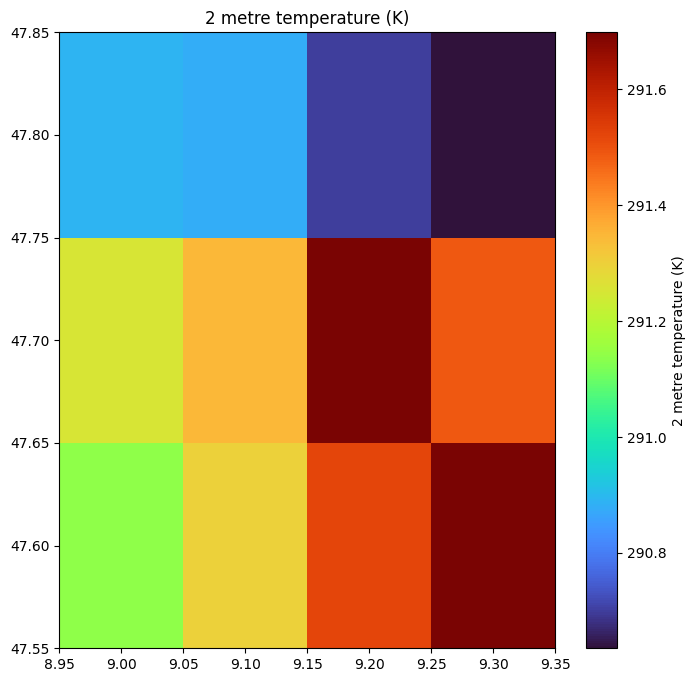

In [6]:
import matplotlib.pyplot as plt

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# Load predefined Colormap
cmap = plt.get_cmap('turbo')

pcm = ax.pcolormesh(lon_list, 
                     lat_list,
                     band_data,
                     cmap=cmap)

plt.colorbar(pcm, ax=ax, label=f'{summary["Long Name"]} ({summary["Units"]})')
ax.set_title(f'{summary["Long Name"]} ({summary["Units"]})')
plt.show()

### Now, lets make the plot a bit more informative

In [7]:
import numpy as np
import math as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Convert the temperature data from K to °C
band_data_C = variable_data[band_index,:,:]-273.15

# Calculate minimum and maxium value within the band data
vmin = np.nanmin(band_data_C)
vmax = np.nanmax(band_data_C)

vmin_floor = ma.floor(vmin * 10) / 10
vmax_ceil = ma.ceil(vmax * 10) / 10

# Compute interval for color bar
interval = 0.1
bins = int((vmax_ceil - vmin_floor)/interval)

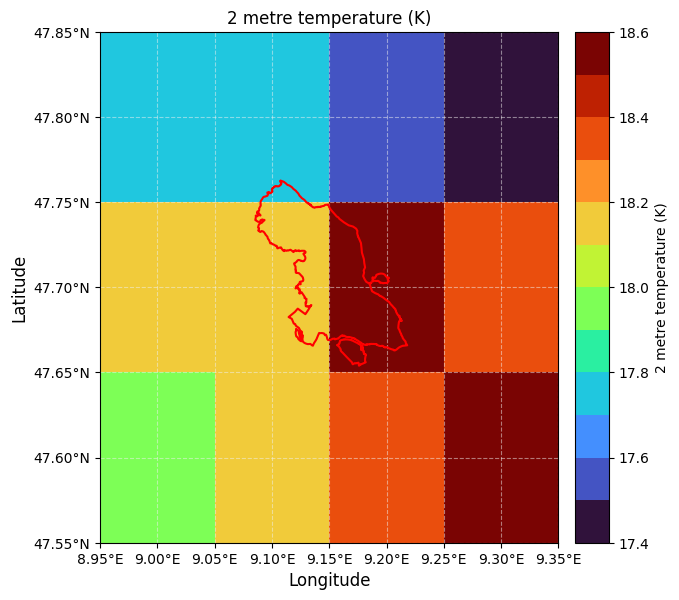

In [8]:
# Function to format latitude tick labels
def format_latitude(x, pos):
    return f"{x:.2f}°N"

# Function to format longitude tick labels
def format_longitude(x, pos):
    return f"{x:.2f}°E"

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# Load predefined Colormap with 10 discrete colors
cmap = plt.get_cmap('turbo', bins)

pcm = ax.pcolormesh(lon_list, 
                     lat_list,
                     band_data_C,
                     cmap=cmap,
                     vmin=vmin_floor,
                     vmax=vmax_ceil)

# Add administrative boundary of Konstanz (Shapefile)
germany_shp = r".\shapefiles\kn_boundary.shp"
germany_boundary = gpd.read_file(germany_shp)
germany_boundary.boundary.plot(ax=ax, edgecolor='red')

# Plot color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95)
plt.colorbar(pcm, cax=cax, label=f'{summary["Long Name"]} ({summary["Units"]})')

# Add grid lines
ax.grid(visible=True, which='major', color='#f0f0f0', linestyle='--', alpha=0.5)

# Set custom tick formatters for latitude and longitude
ax.xaxis.set_major_formatter(FuncFormatter(format_longitude))
ax.yaxis.set_major_formatter(FuncFormatter(format_latitude))

ax.set_title(f'{summary["Long Name"]} ({summary["Units"]})')
ax.set_ylabel('Latitude', fontsize=12)
ax.set_xlabel('Longitude', fontsize=12)

plt.show()

### 3. Create time series plot

Create time series plot for August from year 1950 to 2024

In [9]:
mean_values_list = []
median_values_list = []

total_bands = [(index) for index in range(np.shape(variable_data)[0])]
year_list = [(band_index//12)+1950 for band_index in total_bands]
month_list = [(band_index % 12) + 1 for band_index in total_bands]

for band_index in total_bands:
    band_data = variable_data[band_index,:,:]-273.15
    mean_values_list.append(np.nanmean(band_data))
    median_values_list.append(np.median(band_data))
    
import pandas as pd

df_data = {
    'year': year_list,
    'month': month_list,
    'mean': mean_values_list,
    'median': median_values_list,
}

df_statistics = pd.DataFrame(df_data)
df_statistics

f:\OneDrive - str.ucture GmbH\General\CoKLIMAx (Phase 2)\coklimax\cds_venv\lib\site-packages\numpy\_core\fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


,year,month,mean,median
0,1950,1,-1.677588,-1.677588
1,1950,2,2.095921,2.076715
2,1950,3,4.579808,4.523981
3,1950,4,7.100448,7.199243
4,1950,5,14.580113,14.644403
...,...,...,...,...
893,2024,6,17.800043,17.897211
894,2024,7,20.498244,20.623407
895,2024,8,21.534143,21.669397
896,2024,9,14.937870,15.007043


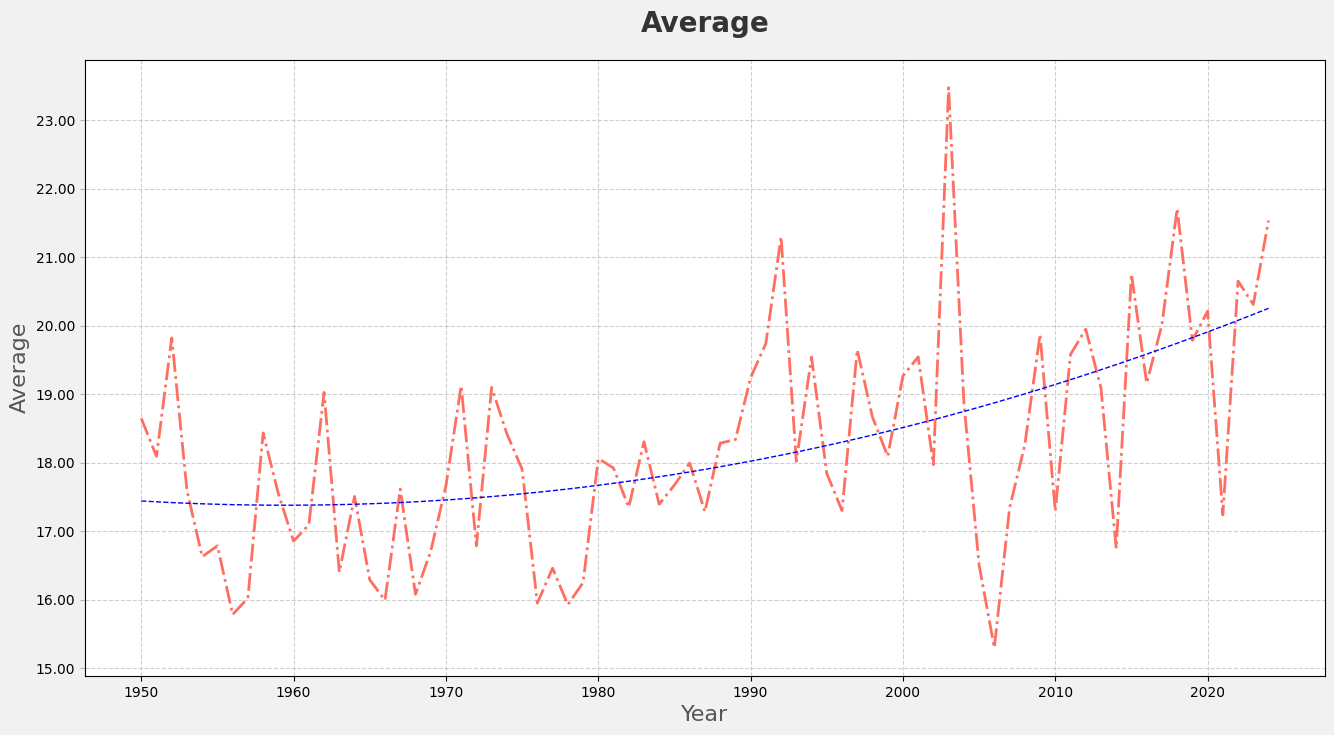

In [10]:
import matplotlib.ticker as ticker

selected_month = 8 # August

# filter the df_statistics by month = 8 (August)
df_statistics_filtered = df_statistics[df_statistics['month']==selected_month]

fig, ax = plt.subplots(figsize=(16, 8), facecolor='#f1f1f1', edgecolor='k')
# Titles and labels
ax.set_title("Average", fontsize=20, fontweight='bold', color='#333333', pad=20)
ax.set_xlabel("Year", fontsize=16, color='#555555')
ax.set_ylabel("Average", fontsize=16, color='#555555')
params = {
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,    
}
plt.rcParams.update(params)

# Grids and ticks
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.tick_params(axis='y', which='both', color='#b0b0b0')

line1, = ax.plot(df_statistics_filtered['year'],
                 df_statistics_filtered['mean'].astype(float),
                 label='Mean',
                 color='#ff6f61',
                 linestyle='-.',
                 linewidth=2.0)

# # Add linear trend line
# slope, intercept = np.polyfit(df_statistics_filtered['year'], df_statistics_filtered['mean'].astype(float), 1)
# trend_line = np.poly1d([slope, intercept])
# plt.plot(df_statistics_filtered['year'], trend_line(df_statistics_filtered['year']), label='Trend Line', color='blue', linestyle='--', linewidth=2)

# Create a curved fit (quadratic, degree 2)
degree = 2  # You can adjust this value for different curve types (degree 2 is a quadratic fit)
coefficients = np.polyfit(df_statistics_filtered['year'], df_statistics_filtered['mean'].astype(float), degree)
curve_fit = np.poly1d(coefficients)

# Plot the curved trend line
plt.plot(df_statistics_filtered['year'], curve_fit(df_statistics_filtered['year']), label=f'Curve Fit (Degree {degree})', color='blue', linestyle='--', linewidth=1)

plt.show()